# 2D CNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
from timeit import default_timer as timer

# Make sure we get reproducible results after each kernel restart
tf.reset_default_graph()
tf.set_random_seed(1337)
np.random.seed(1337)

/home/timluchterhand/Dokumente/PatternRecognition/Assignment12/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/timluchterhand/Dokumente/PatternRecognition/Assignment12/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/timluchterhand/Dokumente/PatternRecognition/Assignment12/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

## Configuration

In [2]:
# General
n_classes = 2
batch_size = 25
epochs = 20
learning_rate = 0.005
data_file = "stl10.pickle"

# Activation function (tanh may not be the best activation function in terms of network performance
# but has advantages when plotting the activation images (due to the limited range))
act_func = tf.nn.tanh

# Regularization (applied to the convolutional layers)
reg_scale = 0.001
regularizer = tf.contrib.layers.l1_regularizer(reg_scale)

# CNN-specific
n_cnn_layers = 3
n_filters = 4
kernel_size = 5
pool_size = 3
pool_stride = 3

## Load data

In [3]:
with open(data_file, "rb") as file:
    data = pickle.load(file)

images = data["images"]
labels = data["labels"]
selected = [100, 700]
selected.extend(list(range(labels.shape[0] - 1, labels.shape[0])))
selected_images = images[selected]
selected_labels = labels[selected]

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=labels.shape[0])
dataset = dataset.batch(batch_size=batch_size)
data_it = dataset.make_initializable_iterator()

example_dataset = tf.data.Dataset.from_tensor_slices((selected_images, selected_labels))
example_dataset = example_dataset.batch(batch_size=selected_labels.shape[0])
example_it = example_dataset.make_initializable_iterator()

## Define network

Input dimensions  of layer 0
(?, 96, 96, 3)
Input dimensions  of layer 1
(?, 30, 30, 4)
Input dimensions  of layer 2
(?, 9, 9, 4)
Output layer shape
(?, 8, 8, 4)
(25, 92, 92, 4)


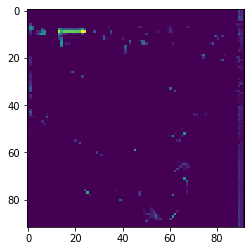

In [4]:
kernel_list = []
    
layers = []
data_in, data_out = data_it.get_next()
for i in range(n_cnn_layers):
    in_tensor = data_in if i == 0 else layers[-1]
    print("Input dimensions  of layer %d" % i)
    print(in_tensor.shape)
    kernel_list.append(tf.Variable(tf.random_normal(shape=(kernel_size, kernel_size, int(in_tensor.shape[-1]), n_filters))))
    layers.append(tf.nn.conv2d(in_tensor, kernel_list[i], strides=(1, 1, 1, 1), padding="VALID", name=("ConvLayer%d" % i)))
    # I assume you want us to use relu???
    layers.append(tf.nn.relu(layers[i]))
    layers.append(tf.nn.avg_pool(layers[i + 1], ksize=(1, kernel_size, kernel_size, 1), strides=(1, pool_stride, pool_stride, 1), padding="VALID", name=("Pool%d" % i)))
    
print("Output layer shape")
print(layers[-1].shape)
flat_dims = layers[-1].shape[1] * layers[-1].shape[2] * layers[-1].shape[3]
layers.append(tf.reshape(layers[-1], (-1, flat_dims)))

fc_weights = tf.Variable(tf.random_normal(shape=(int(layers[-1].shape[-1]), 2)))
bias = tf.Variable(tf.random_normal(shape=(2, )))
layers.append(tf.add(tf.matmul(layers[-1], fc_weights), bias))

# @TODO add regularizer!
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layers[-1], labels=data_out)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

classify_correct = tf.cast(tf.equal(tf.argmax(layers[-1], axis=0), data_out), dtype=tf.int8)
accuracy = tf.reduce_sum(classify_correct) / batch_size

with tf.Session() as sess:
    sess.run(data_it.initializer)
    sess.run(example_it.initializer)
    sess.run(tf.global_variables_initializer())
    feature_maps_layer_1 = sess.run(layers[1])
    print(feature_maps_layer_1.shape)
    plt.imshow(feature_maps_layer_1[0, :, :, 0])
    # sess.run(optimizer)
    # ding, _ = sess.run(data_it.get_next())
    # plt.imshow(ding[0, :, :, :])
